## Feature Engineering

In this section we will: 
- Evaluate a Dummy Classifier
- Compare Cross-Validation Results with no Hyperparameter Tuning for: 
    - Dataset with Amount Features
    - Dataset with Ratio Features
- Check Multi-collinearity
- Evaluate Feature Importance
    - Permutation Importance 
    - Feature Selector Performance across different values of n
    - Examine Feature Strength

In [342]:
#import custom modules
from importlib import reload
from helpers.my_imports import *
import helpers.preprocessing as pp
import helpers.plot as plot
import helpers.tools as tools
import helpers.transformers as xfrs
from helpers.reload import myreload

#make sure latest copy of library is loaded
myreload()

#Global Variable for Random State
rs=42 #random_state

#Load dataset
df = pd.read_csv('saved_dfs/preprocessed_negotiations_df.csv')
df.head(2)

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


,claim_type,NSA_NNSA,split_claim,negotiation_type,in_response_to,level,facility,carrier,group_number,plan_funding,TPA,TPA_rep,billed_amount,negotiation_amount,offer,counter_offer,decision,service_days,decision_days,offer_days,counter_offer_days,YOB,neg_to_billed,offer_to_neg,offer_to_counter_offer
0,HCFA,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 3,Cedar Hill,Cigna,3344605,FULLY,Zelis,Marissa Pepe,4058.0,4058.0,258.0,3449.0,Rejected,128.0,NaN,0.0,0.0,1984,1.0,0.0636,0.0748
1,UB,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 5,Cedar Hill,Blue Cross Blue Shield,174518M3BH,SELF,Zelis,Courtney Kiernan,52253.0,52253.0,12500.0,44415.0,Rejected,127.0,NaN,2.0,2.0,2021,1.0,0.2392,0.2814


### Define X and y

In [343]:
#Define X and y
X,y=df.drop(columns='decision'), df.decision

#Split and stratify the data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((6398, 24), (2133, 24))

In [344]:
pp.mystats(X, nulls_only=True)

(8531, 24)


,nulls,null_pct,dimensions
decision_days,1883,22.07,44
offer_days,364,4.27,54
counter_offer_days,199,2.33,56
service_days,1,0.01,511


### Define scoring metrics

In [345]:
scoring_metrics = {
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0.0),
    'precision_weighted': make_scorer(precision_score, average='weighted',  zero_division=0.0)
}

### Dummy Classifier

In [346]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='uniform', random_state=rs).fit(X_train, y_train)
dummy_test_preds = dummy_clf.predict(X_test)

In [351]:
print(f"The dummy classifier returns an F1 weighted score of: {f1_score(y_test, dummy_test_preds, average='weighted'):.3f}")

The dummy classifier returns an F1 weighted score of: 0.588


### Feature Encoding
- OneHotEncode features with less than 10 categories
- Ordinal Encoding for level (levels 2-5)
- We will start with Binary Encoding for features with more than 10 categories.  Later we will also try TargetEncoding and CatBoostEncoding due to the high number of rare values in some of the columns 

In [350]:
#Display number of dimensions for categorical features with more than 3 dimensions to help make encoding decisions
pp.mystats(X[['in_response_to', 'facility', 'carrier', 'TPA', 'TPA_rep', 'group_number']])

(8531, 6)


,nulls,null_pct,dimensions
in_response_to,0,0.0,6
facility,0,0.0,8
carrier,0,0.0,53
TPA,0,0.0,42
TPA_rep,0,0.0,613
group_number,0,0.0,1748


### Define Models

In [352]:
#define models with mainly default settings.  Increased max_iter for logistic function due to a convergence warnings
models = {
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=rs), 
    'Ridge Classifier': RidgeClassifier(random_state=rs),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'Decision Trees': DecisionTreeClassifier(random_state=rs),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=rs, n_jobs=-1),
    'SVM': SVC(probability=False, random_state=rs), 
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=rs), 
    'Bagging': BaggingClassifier(n_estimators=10, random_state=rs, n_jobs=-1), 
    'Gradient Boost': GradientBoostingClassifier(n_estimators=100, random_state=rs)
}

#### Cross-Validation with default parameters
- The function `my_cross_val` does the following: 
    - dynamically builds a copy of the dataset containing just columns passed in as arguments
    - dynamically builds the transformer and pipeline based on arguments passed
    - Returns the mean of the scores from cross_validate() for each model passed in 
    - saves the models and results 
- We use a realistic pipeline for our initial testing:
    - imputer for nulls, 
    - yeo-johnson transformer
    - polynomial features
    - categorical column encoding
    - oversampler/undersampler
    - scaler
- This test will use the amount columns

In [353]:
_=tools.my_cross_val(df,'decision',scoring_metrics, models,
                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  
                   num_transformer=('yeo', PowerTransformer(method='yeo-johnson')), 
                   poly=('poly', PolynomialFeatures(include_bias=False)),
                   num_cols=['negotiation_amount', 'billed_amount', 'offer', 'counter_offer', 
                             'counter_offer_days', 'offer_days', 'decision_days', 'service_days', 'YOB'],
                   
                   cat_encoder=('cat_encoder', BinaryEncoder()),
                   cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'], 
                   
                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),
                   ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 'facility', 'plan_funding'],
                   ord_cols=['level'], 
                                     
                   oversampler=('over', SMOTE(random_state=42)),
                   undersampler=('under', RandomUnderSampler(random_state=42)),
                                     
                   scaler= ('scaler', StandardScaler()),
            
                   set_name='fe_set1', cv=5, verbose=0,
                   test_size=0.25, stratify=True,rs=42)

model,fit_time,score_time,test_f1_weighted,train_f1_weighted,test_precision_weighted,train_precision_weighted
Logistic Regression,0.153869,0.011838,0.931676,0.957343,0.942174,0.965951
Ridge Classifier,0.076553,0.017762,0.924278,0.936147,0.943071,0.953217
KNN,0.081431,0.027758,0.853216,0.891662,0.913038,0.942554
Decision Trees,0.225711,0.013747,0.895154,1.000000,0.900717,1.000000
Random Forest,0.756063,0.032178,0.928476,1.000000,0.929944,1.000000
SVM,0.267746,0.061517,0.920149,0.973328,0.923966,0.977882
AdaBoost,2.386636,0.031630,0.924431,0.976123,0.926757,0.976174
Bagging,0.825403,0.023305,0.906630,0.995579,0.913586,0.995662
Gradient Boost,5.205452,0.030038,0.933611,0.980425,0.935028,0.980595


#### Cross-Validation using Simple Models with default parameters using Ratio columns instead of Amount columns

In [354]:
fit_models_with_ratios=tools.my_cross_val(df,'decision',scoring_metrics, models,
                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  
                   num_transformer=('yeo', PowerTransformer(method='yeo-johnson')), 
                   poly=('poly', PolynomialFeatures(include_bias=False)),
                   num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer',  
                             'counter_offer_days', 'offer_days', 'decision_days', 'service_days', 'YOB'],
                   
                   cat_encoder=('cat_encoder', BinaryEncoder()),
                   cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'], 
                   
                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),
                   ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 'facility', 'plan_funding'],
                   ord_cols=['level'], 
                                     
                   oversampler=('over', SMOTE(random_state=42)),
                   undersampler=('under', RandomUnderSampler(random_state=42)),
                                     
                   scaler= ('scaler', StandardScaler()),
            
                   set_name='fe_set2', cv=5, verbose=0,
                   test_size=0.25, stratify=True,rs=42)

model,fit_time,score_time,test_f1_weighted,train_f1_weighted,test_precision_weighted,train_precision_weighted
Logistic Regression,0.119926,0.018253,0.934837,0.956928,0.944466,0.965682
Ridge Classifier,0.091996,0.018291,0.931633,0.939352,0.946940,0.955264
KNN,0.048271,0.022831,0.900877,0.928050,0.934277,0.954304
Decision Trees,0.159926,0.011311,0.913146,1.000000,0.916765,1.000000
Random Forest,0.560742,0.028781,0.940682,1.000000,0.945169,1.000000
SVM,0.203668,0.044690,0.934571,0.973317,0.937853,0.977844
AdaBoost,1.606072,0.020209,0.934242,0.978550,0.936125,0.978920
Bagging,0.642828,0.021872,0.932873,0.995235,0.937142,0.995355
Gradient Boost,3.809840,0.011459,0.936242,0.981828,0.939149,0.982584


There is an improvement using ratios for almost all the models.  As a result we will drop the amount features and use the ratios going forward 

### Redefine X and y

In [356]:
#Define X and y so we can check multicollinearity and evaluate permutation importance
X,y=df.drop(columns=['decision', 'billed_amount', 'negotiation_amount', 'offer', 'counter_offer']), df.decision

#Split and stratify the data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((6398, 20), (2133, 20))

### Check Multicolinearity 
Calculate VIF after using SimpleImputer with strategy= most_frequent

In [357]:
tools.vif(X, impute_strategy='most_frequent').sort_values(by='VIF', ascending = False)

,VIF
offer_to_neg,8.631281
offer_to_counter_offer,8.418126
offer_days,3.296877
counter_offer_days,3.232707
decision_days,1.636780
service_days,1.047615
neg_to_billed,1.016720
YOB,1.001126


offer_to_neg and offer_counter_offer is high but under 10 which is still acceptable especially considering that the models seem to perform better using ratio

### Evaluate Permutation Importance
This technique involves randomly shuffling individual features and measuring the change in the model's performance. Features that cause a significant drop in performance when permuted are deemed important because the model relies on them for making accurate predictions. We look at these results for Logistic Regression, KNN and SVM

In [358]:
tools.my_permutation_importance(fit_models_with_ratios, X_test, y_test, scoring=scoring_metrics['f1_weighted'], 
                                n_repeats=30, rs=42)

Logistic Regression:


Variables,offer_to_neg,negotiation_type,offer_to_counter_offer,NSA_NNSA,service_days,carrier,counter_offer_days,plan_funding,offer_days,decision_days,TPA_rep,split_claim,group_number,facility,TPA,YOB,neg_to_billed,in_response_to,level,claim_type
Score,0.062602,0.035714,0.024558,0.014362,0.00319,0.003042,0.003002,0.002384,0.001939,0.001544,0.000579,0.000579,0.000483,0.00047,0.000396,0.000372,0.000295,0.000209,0.0,-0.004223


Ridge Classifier:


Variables,offer_to_neg,negotiation_type,NSA_NNSA,carrier,facility,counter_offer_days,decision_days,split_claim,level,group_number,plan_funding,service_days,in_response_to,YOB,neg_to_billed,TPA_rep,offer_days,claim_type,TPA,offer_to_counter_offer
Score,0.105149,0.005965,0.005539,0.002172,0.001204,0.00085,0.000173,0.0,0.0,-0.000275,-0.000296,-0.000537,-0.000764,-0.001148,-0.001478,-0.002366,-0.002768,-0.003491,-0.003912,-0.007372


KNN:


Variables,offer_to_counter_offer,offer_to_neg,service_days,carrier,in_response_to,facility,plan_funding,TPA,negotiation_type,neg_to_billed,TPA_rep,decision_days,counter_offer_days,claim_type,offer_days,level,group_number,split_claim,NSA_NNSA,YOB
Score,0.009632,0.009273,0.006464,0.006114,0.00598,0.004102,0.004082,0.00396,0.003948,0.003512,0.002645,0.002632,0.00232,0.002149,0.001295,0.001097,0.000525,-0.000535,-0.000683,-0.00121


Decision Trees:


Variables,offer_to_neg,offer_to_counter_offer,offer_days,group_number,plan_funding,decision_days,counter_offer_days,in_response_to,neg_to_billed,TPA,negotiation_type,carrier,YOB,NSA_NNSA,split_claim,service_days,claim_type,level,facility,TPA_rep
Score,0.129548,0.055814,0.010579,0.010564,0.009808,0.008795,0.005992,0.005125,0.004828,0.004436,0.003145,0.002434,0.001423,0.000687,0.000141,-0.000021,-0.000064,-0.000596,-0.000899,-0.00187


Random Forest:


Variables,offer_to_neg,offer_to_counter_offer,decision_days,offer_days,group_number,plan_funding,neg_to_billed,YOB,claim_type,carrier,negotiation_type,in_response_to,service_days,TPA_rep,NSA_NNSA,level,facility,split_claim,TPA,counter_offer_days
Score,0.074164,0.062592,0.003719,0.003376,0.003142,0.003139,0.002873,0.001737,0.001585,0.001297,0.00121,0.00077,0.000698,0.000608,0.000505,0.000262,0.000208,0.0,-0.000641,-0.001864


SVM:


Variables,offer_to_neg,offer_to_counter_offer,offer_days,service_days,negotiation_type,in_response_to,neg_to_billed,TPA,decision_days,carrier,plan_funding,group_number,facility,YOB,NSA_NNSA,counter_offer_days,level,split_claim,TPA_rep,claim_type
Score,0.058317,0.038071,0.00553,0.004715,0.004021,0.003745,0.003464,0.003015,0.002882,0.002831,0.002639,0.002426,0.001574,0.001033,0.000676,0.000667,0.000517,0.000088,-0.001456,-0.001561


AdaBoost:


Variables,offer_to_neg,offer_to_counter_offer,negotiation_type,TPA_rep,claim_type,offer_days,neg_to_billed,plan_funding,level,group_number,service_days,counter_offer_days,NSA_NNSA,facility,YOB,split_claim,decision_days,carrier,in_response_to,TPA
Score,0.079832,0.02404,0.014686,0.004361,0.004158,0.00389,0.003513,0.003497,0.003374,0.002627,0.001997,0.00198,0.001831,0.001246,0.001085,0.000994,0.00052,0.0,0.0,-0.000354


Bagging:


Variables,offer_to_neg,offer_to_counter_offer,plan_funding,counter_offer_days,decision_days,offer_days,service_days,group_number,neg_to_billed,facility,TPA_rep,negotiation_type,in_response_to,TPA,YOB,carrier,NSA_NNSA,split_claim,level,claim_type
Score,0.112859,0.02878,0.00954,0.007524,0.007327,0.006853,0.005233,0.002681,0.002616,0.002572,0.002415,0.002106,0.001689,0.001478,0.001453,0.001355,0.000393,-0.000049,-0.000249,-0.001774


Gradient Boost:


Variables,offer_to_neg,offer_to_counter_offer,plan_funding,TPA_rep,group_number,in_response_to,TPA,offer_days,neg_to_billed,claim_type,carrier,decision_days,counter_offer_days,facility,level,YOB,NSA_NNSA,split_claim,negotiation_type,service_days
Score,0.084681,0.017629,0.004008,0.003752,0.00371,0.002694,0.002487,0.001913,0.001883,0.001501,0.000865,0.000864,0.000477,0.000281,0.000036,0.000033,0.0,0.0,-0.000237,-0.000348


The results show that the most important features overall across all models are offer_to_neg and offer_to_counter_offer.  The other results are mostly model dependent. 

### Evaluate effects of a Feature Selector for varying values of max_features
To try to get a better idea of the important features and the number of important features, we evaluate our models against varying values of `max_features` to be selected in a `SelectFromModel`/`LogisticRegression` selector. 

#### Define New Baseline CV Transformer
For this test we define a new cross-validation  transformer which incorporates the observations from EDA and   includes steps we are plan to use in Cross-Validation.  We include: 
- `yeo_johnson PowerTransformer` which will be applied to numeric features related to amounts and number of days (as discussed in EDA)
- `RareCategoryCombiner2` which will combine rare categories below a threshold to a value of `Unknown` 

In [359]:
#Assign column categories
ohe_cols = ['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 
            'facility', 'plan_funding']
cat_cols = ['carrier', 'TPA', 'group_number','TPA_rep']
ord_cols = ['level']
num_cols = ['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer',
            'service_days', 'offer_days', 'counter_offer_days', 'decision_days', 'YOB']

#Transformer includes yeo-johnson Power Transformer 
#Transformer also includes a class to combine rare categories
baseline_cv_transformer = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            #('log', #xfrs.LogTransformer(add_constant=1)),  # Applying log transform
            ('yeo', PowerTransformer(method='yeo-johnson')), 
            ('poly', PolynomialFeatures(include_bias=False))
        ]), num_cols),
        ('cat', Pipeline([
            ('combiner', xfrs.RareCategoryCombiner2(threshold=20)),
            ('cat_encoder', BinaryEncoder())
        ]), cat_cols),
        ('ohe', OneHotEncoder(), ohe_cols),
        ('ord', OrdinalEncoder(), ord_cols)
    ],
    remainder='passthrough'
)
baseline_cv_transformer.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('yeo', PowerTransformer()),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['neg_to_billed', 'offer_to_neg',
                                  'offer_to_counter_offer', 'service_days',
                                  'offer_days', 'counter_offer_days',
                                  'decision_days', 'YOB']),
                                ('cat',
                                 Pipeline(steps=[('combiner',
                                                  RareCategoryCombiner2(threshold=20)),
                                                 ('cat_encoder',
                                                  BinaryEncoder())]),
                                 ['carrier', 'TPA', 'group_number', 'TPA_rep']),
                                ('ohe', OneHotEncoder(),
                                 ['claim_type', 'NSA_NNSA', 'split_claim',
                                  'negotiation_type', 'in_response_to',
                                  'facility', 'plan_funding']),
                                ('ord', OrdinalEncoder(), ['level'])])

In [360]:
#Get Total Number of Features
total_num_features = baseline_cv_transformer.output_indices_['ord'].stop
total_num_features

90

For this test we will exclude `DecisionTreeClassifier` and `RidgeClassifier` since we have similar models in our set. 
#### Calculate cross-validation scores for each model and value of max_features

In [363]:
#Define list of models 
simple_models = {
    'lgr': LogisticRegression(max_iter=1000, random_state=rs, n_jobs=1), 
    'knn': KNeighborsClassifier(n_jobs=-1),
    'rf': RandomForestClassifier(n_estimators=100, random_state=rs, n_jobs=-1),
    'svm': SVC(probability=False, random_state=rs), 
    'ada': AdaBoostClassifier(n_estimators=100, random_state=rs), 
    'bag': BaggingClassifier(n_estimators=10, random_state=rs, n_jobs=-1), 
    'gbc': GradientBoostingClassifier(n_estimators=100, random_state=rs)
}

#Cross-Validation for each model across values of n greater or equal to 5
sfm_scores=pd.DataFrame()
for model_name, model in simple_models.items(): 
    n_indices, scores=[], []
    print(f"Calculating scores for: {model_name}")
    for n in np.arange(5,86,1):  
 
        # Full pipeline with oversampling, undersampling, scaling, and logistic regression
        sfm_cv_pipe = ImbPipeline([
            ('transformer', baseline_cv_transformer),
            ('over', SMOTE(random_state=42)),
            ('under', RandomUnderSampler(random_state=42)),
            ('scaler', RobustScaler()),
            ('selector', SelectFromModel(max_features=n, 
                             estimator=LogisticRegression(penalty='l1', C=1, solver='liblinear', 
                                                          max_iter=5_000, random_state=rs, n_jobs=1))),
            ('clf', model)
        ])

        #Fit Pipe
        sfm_cv_pipe.fit(X_train, y_train)

        #Calculate CV Score
        scores.append(cross_val_score(sfm_cv_pipe, X_test, y_test, scoring=scoring_metrics['f1_weighted'], cv=5).mean())
        n_indices.append(n)
    sfm_scores[model_name]=scores
    sfm_scores.index=n_indices
    
#save sfm_scores
sfm_scores.to_csv('saved_dfs/sfm_scores.csv', index=False)

Calculating scores for: lgr
Calculating scores for: knn
Calculating scores for: rf
Calculating scores for: svm
Calculating scores for: ada
Calculating scores for: bag
Calculating scores for: gbc


#### Visualize cross-validation scores for different models and values of max_features

In [364]:
#To retrieve sfm_scores without re-running the code above, uncomment the code
#sfm_scores = pd.read_csv('saved_dfs/sfm_scores.csv')

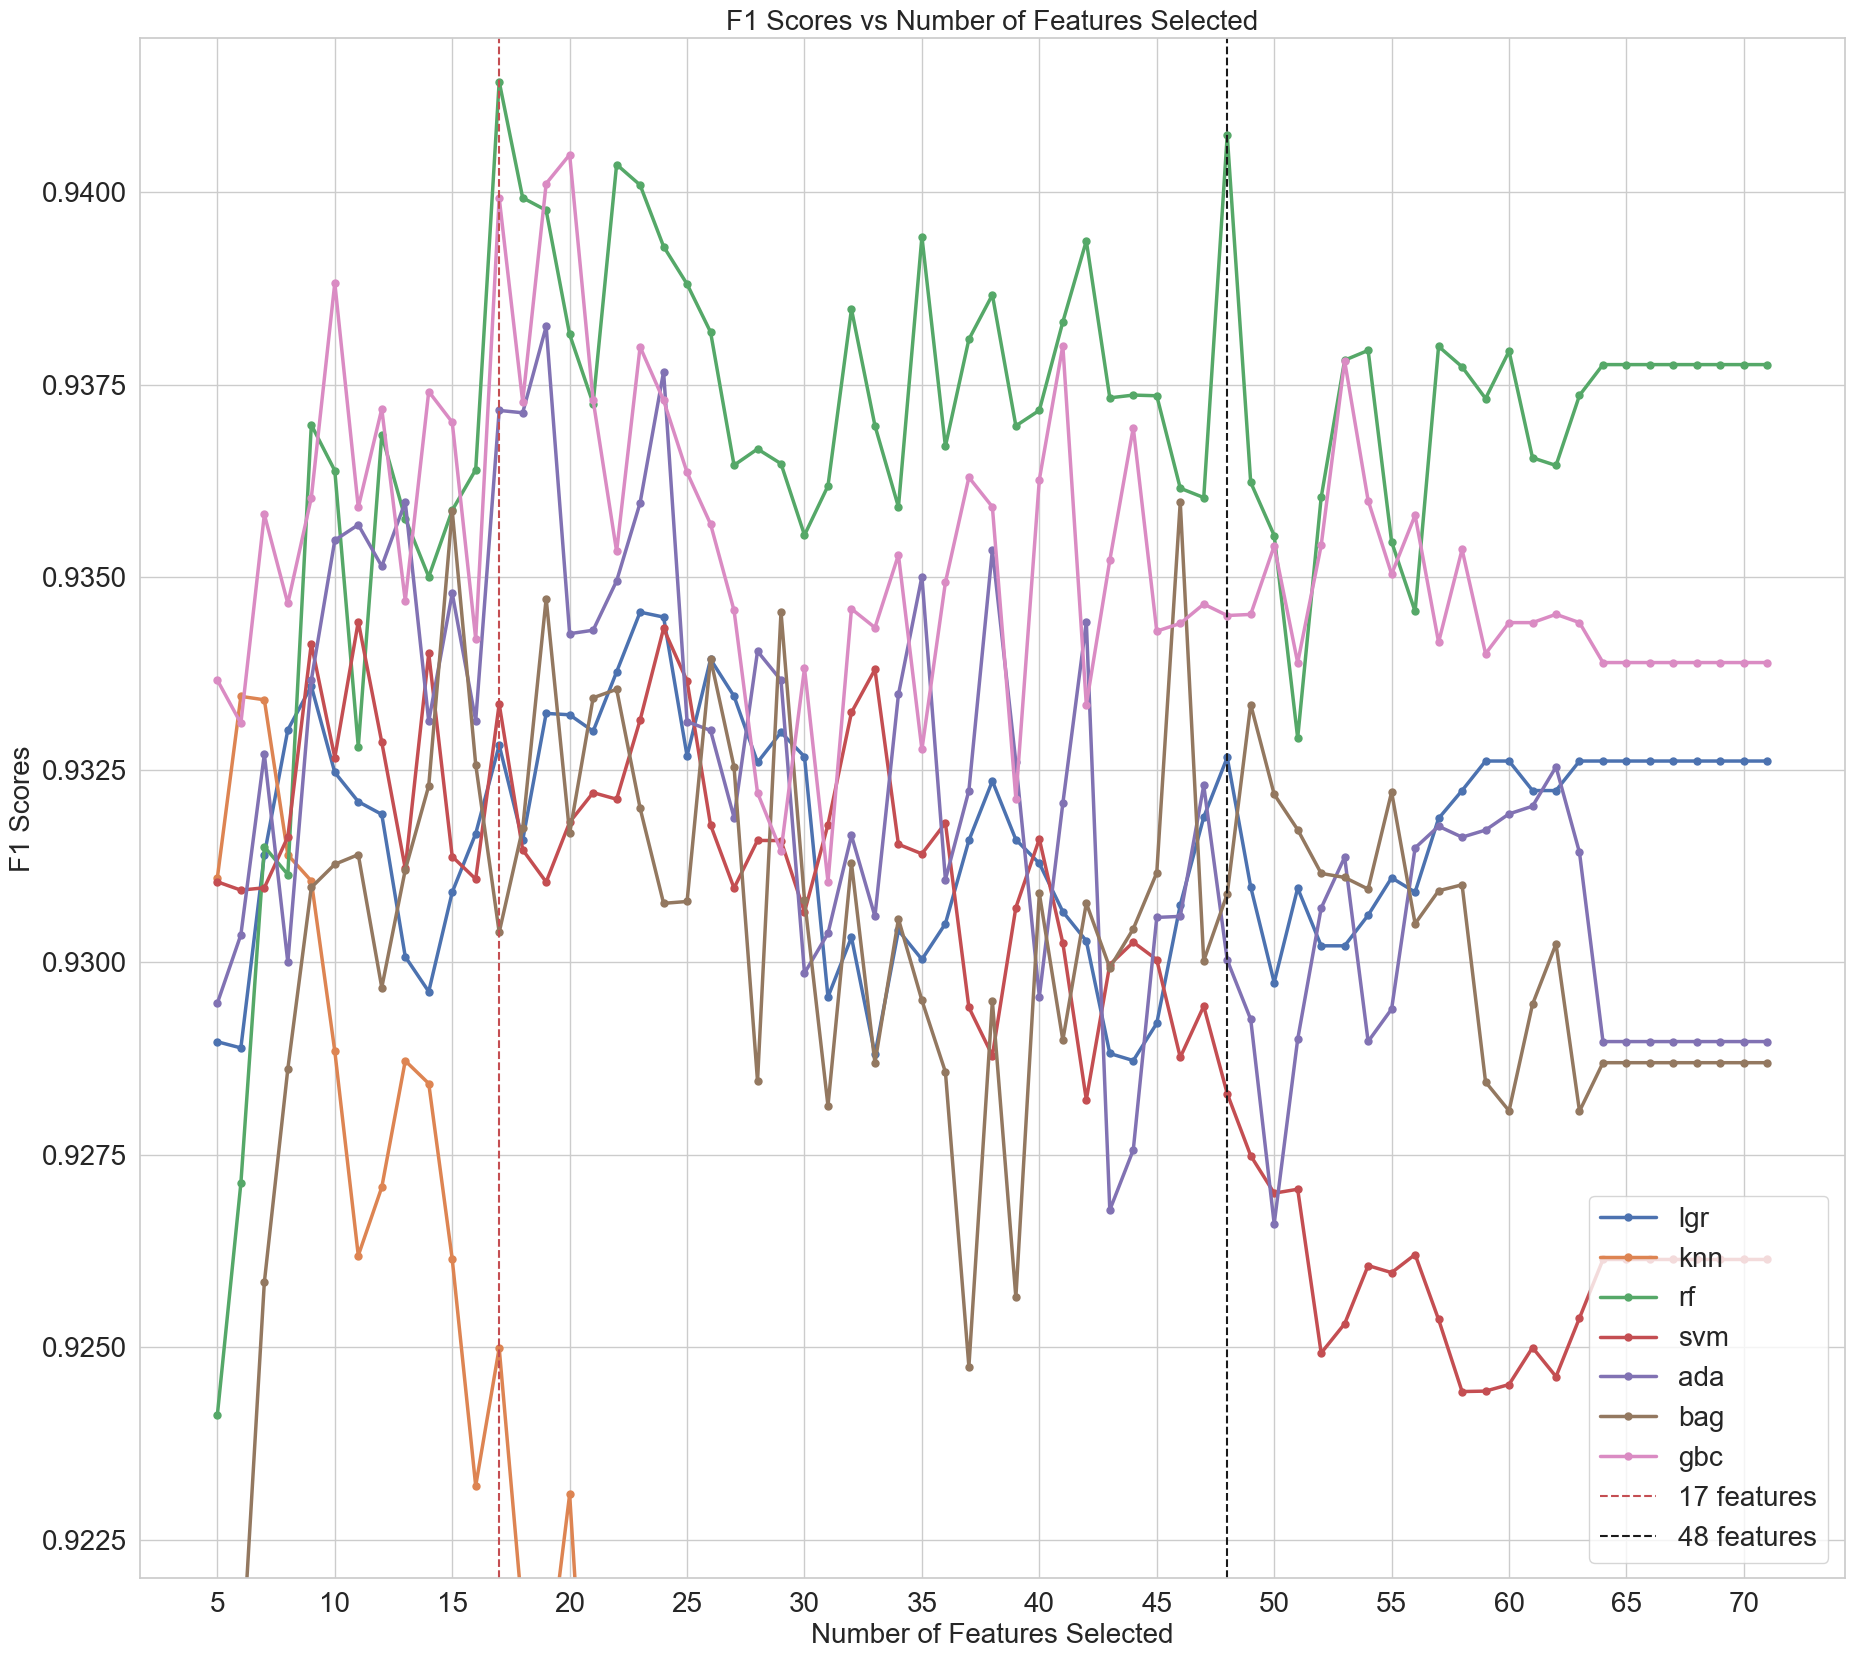

In [369]:
lower_bound=17
upper_bound=48

# Set figure size, style and common font size for labels and ticks
plt.figure(figsize=(22, 20))
sns.set(style="whitegrid", font_scale=1)
common_fontsize = 20

#Plot classifier scores vs n_features_to_select 
for column in sfm_scores.columns:
    plt.plot(sfm_scores.index[sfm_scores.index <= 71], sfm_scores[column][sfm_scores.index <= 71], label=column, marker='o', linewidth=2.5, markersize=5)

plt.axvline(x=lower_bound, color='r', linestyle='--', label=f'{lower_bound} features')
plt.axvline(x=upper_bound, color='k', linestyle='--', label=f'{upper_bound} features')
plt.title('F1 Scores vs Number of Features Selected', fontsize=common_fontsize)
plt.ylabel('F1 Scores',fontsize=common_fontsize)
plt.xlabel('Number of Features Selected',fontsize=common_fontsize)
plt.xticks(np.arange(5, 75, 5),fontsize=common_fontsize)
plt.yticks(fontsize=common_fontsize)
plt.ylim(0.922, 0.942)
plt.legend(loc=(0.85, 0.01), fontsize=common_fontsize)

plt.show()

#### Observations related to  Feature Selection for different values of n: 
- It looks like for most models n=17 to n=48 is the most interesting range, although RandomForest continues to do well up until ~n=41

Below we take a look at the features that are remain at n=48

#### View selected features for n=48

In [375]:
cv_baseline_pipe = ImbPipeline([
            ('transformer', baseline_cv_transformer),
            ('over', SMOTE(random_state=42)),
            ('under', RandomUnderSampler(random_state=42)),
            ('scaler', RobustScaler()),
            ('selector', SelectFromModel(max_features=48, 
                             estimator=LogisticRegression(penalty='l1', C=1, solver='liblinear', 
                                                          max_iter=5_000, random_state=rs, n_jobs=1))),
            #('clf', LogisticRegression(max_iter=1000, random_state=rs, n_jobs=1))
        ])

cv_baseline_pipe.fit(X_train, y_train)
selected_features, discarded_features = tools.custom_get_feature_names(cv_baseline_pipe)
selected_features

array(['offer_to_neg', 'offer_to_counter_offer', 'service_days',
       'offer_days', 'counter_offer_days', 'decision_days', 'YOB',
       'neg_to_billed^2', 'neg_to_billed offer_to_neg',
       'neg_to_billed offer_to_counter_offer', 'neg_to_billed offer_days',
       'neg_to_billed counter_offer_days', 'offer_to_neg^2',
       'offer_to_neg offer_to_counter_offer', 'offer_to_neg service_days',
       'offer_to_neg decision_days', 'offer_to_neg YOB',
       'offer_to_counter_offer^2',
       'offer_to_counter_offer counter_offer_days', 'offer_days^2',
       'offer_days counter_offer_days', 'offer_days decision_days',
       'counter_offer_days^2', 'counter_offer_days decision_days',
       'decision_days YOB', 'YOB^2', 'carrier_0', 'carrier_2', 'TPA_0',
       'TPA_2', 'group_number_0', 'group_number_1', 'group_number_2',
       'group_number_4', 'group_number_5', 'TPA_rep_2', 'TPA_rep_5',
       'claim_type_HCFA', 'claim_type_UB', 'NSA_NNSA_NNSA',
       'NSA_NNSA_NSA', 'split_claim

We note that the features `level` was discarded
#### Compare results for Select From Model with RFE with default settings

In [376]:
# Full pipeline with oversampling, undersampling, scaling, and logistic regression
rfe_cv_pipe = ImbPipeline([
    ('transformer', baseline_cv_transformer),
    ('over', SMOTE(random_state=48)),
    ('under', RandomUnderSampler(random_state=42)),
    ('scaler', RobustScaler()),
    ('selector', RFE(estimator=LogisticRegression(penalty='l1', C=1, solver='liblinear', 
                                                  max_iter=5_000, random_state=rs, n_jobs=1))),
    ('lgr', LogisticRegression(max_iter=3000, random_state=rs, n_jobs=1))
])

#Fit Pipe
rfe_cv_pipe.fit(X_train, y_train)
rfe_selected_features, rfe_discarded_features = tools.custom_get_feature_names(rfe_cv_pipe)
rfe_selected_features

array(['offer_to_neg', 'offer_to_counter_offer', 'service_days',
       'offer_days', 'counter_offer_days', 'decision_days', 'YOB',
       'neg_to_billed^2', 'neg_to_billed offer_to_neg',
       'neg_to_billed offer_to_counter_offer', 'neg_to_billed offer_days',
       'neg_to_billed counter_offer_days', 'offer_to_neg^2',
       'offer_to_neg service_days', 'offer_to_neg counter_offer_days',
       'offer_to_neg decision_days', 'offer_to_neg YOB',
       'offer_to_counter_offer counter_offer_days', 'offer_days^2',
       'offer_days counter_offer_days', 'offer_days YOB',
       'counter_offer_days^2', 'decision_days YOB', 'YOB^2', 'carrier_0',
       'carrier_2', 'TPA_0', 'TPA_2', 'group_number_0', 'group_number_1',
       'group_number_2', 'group_number_4', 'group_number_5', 'TPA_rep_2',
       'TPA_rep_5', 'claim_type_HCFA', 'NSA_NNSA_NNSA', 'NSA_NNSA_NSA',
       'split_claim_No', 'negotiation_type_NNSA Negotiation',
       'negotiation_type_Open Negotiation',
       'in_response_to

In [377]:
set(selected_features) - set(rfe_selected_features)

{'claim_type_UB',
 'counter_offer_days decision_days',
 'in_response_to_Corrected Claim',
 'offer_days decision_days',
 'offer_to_counter_offer^2',
 'offer_to_neg offer_to_counter_offer'}

In [378]:
set(rfe_selected_features) - set(selected_features)

{'facility_Frisco', 'offer_days YOB', 'offer_to_neg counter_offer_days'}

Again we see `level` is not part of the selected features

#### Retest without level
Since `level` is not part of the first 41 features selected, nor part of the retained features with RFE, we redo our cross-validation without it

In [379]:
_=tools.my_cross_val(df,'decision',scoring_metrics, models,
                   num_imputer=('si',SimpleImputer(strategy='most_frequent')),  
                   num_transformer=('yeo', PowerTransformer(method='yeo-johnson')), 
                   poly=('poly', PolynomialFeatures(include_bias=False)),
                   num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer',  
                             'counter_offer_days', 'offer_days', 'decision_days', 'service_days', 'YOB'],
                   
                   cat_encoder=('cat_encoder', BinaryEncoder()),
                   cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'], 
                   
                   onehotencoder=('ohe', OneHotEncoder(drop='if_binary')),
                   ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type', 'in_response_to', 'facility', 'plan_funding'],
                   ord_cols=[],  #['level'], 
                                     
                   oversampler=('over', SMOTE(random_state=42)),
                   undersampler=('under', RandomUnderSampler(random_state=42)),
                                     
                   scaler= ('scaler', StandardScaler()),
            
                   set_name='fe_set3', cv=5, verbose=0,
                   test_size=0.25, stratify=True,rs=42)

model,fit_time,score_time,test_f1_weighted,train_f1_weighted,test_precision_weighted,train_precision_weighted
Logistic Regression,0.105900,0.010197,0.934465,0.957053,0.944312,0.965902
Ridge Classifier,0.068694,0.009553,0.930939,0.939661,0.947018,0.955506
KNN,0.047714,0.024204,0.905980,0.928499,0.936008,0.954351
Decision Trees,0.148661,0.010595,0.914799,1.000000,0.917621,1.000000
Random Forest,0.520984,0.030796,0.938826,1.000000,0.944547,1.000000
SVM,0.150580,0.040093,0.935022,0.973107,0.938166,0.977705
AdaBoost,1.586710,0.017189,0.929454,0.977476,0.931731,0.977804
Bagging,0.554588,0.016552,0.925232,0.994883,0.932004,0.994995
Gradient Boost,3.672256,0.011228,0.936420,0.981697,0.939824,0.982410


The results for `level` are mixed both in the Permutation Importance Section and in the Feature Selection Tests so we will keep it

#### Feature Regularization
- We will examine feature strength after regularization for different values of C in a LogisticRegression Model. 
- We will only look at a few low dimension features because otherwise the plot would get too crowded to be interpretable 
- For this exercise we skip PolynomialFeatures otherwise the graph would get too crowded
- We will also skip oversampling/undersampling

In [380]:
#Select low dimensionality features 
ohe_cols_FR = ['NSA_NNSA', 'split_claim', 'claim_type'] 
binary_cols_FR = [] 
ordinal_cols_FR = []
numerical_cols_FR =['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
                    'service_days', 'offer_days', 'counter_offer_days']

In [381]:
#Define X_FR as subset of X
X_FR=X[ohe_cols_FR+binary_cols_FR+ordinal_cols_FR+numerical_cols_FR]

In [382]:
#Define Feature Regularization Transformer
transformer_FR = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('yeo', PowerTransformer(method='yeo-johnson')), 
        ]), numerical_cols_FR),
        ('ohe', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'), ohe_cols_FR),
        ('binary', BinaryEncoder(), binary_cols_FR),
        ('ordinal', OrdinalEncoder(), ordinal_cols_FR)
    ], remainder='passthrough')

In [383]:
#define pipeline for Feature Regularization Testing.  Skip oversampler and undersampler 
pipe_FR = ImbPipeline([
            ('transformer', transformer_FR),
            ('scaler', RobustScaler()) ])

In [384]:
X_FR_transformed = pipe_FR.fit_transform(X_FR, y)

In [385]:
X_FR_transformed.shape, y.shape

((8531, 9), (8531,))

In [386]:
transf = pipe_FR.named_steps['transformer']
ohe_feature_names = list(transf.named_transformers_['ohe'].get_feature_names_out())

In [387]:
#Set value of Cs so that we have a wide range of C values on the lower end of the scale where regularization is strongest
Cs = np.logspace(-5, .5) 
coef_list = []

#Run Logistic Regression for different values of C
for C in Cs:
    #libinear is for small datasets and ovr and supports l1 and l2
    logreg = LogisticRegression(penalty='l1', solver ='liblinear', C=C, random_state=42, max_iter=1000)
    logreg.fit(X_FR_transformed,y)
    coef_list.append(list(logreg.coef_[0]))

coef_df = pd.DataFrame(coef_list, columns = ohe_feature_names+numerical_cols_FR)
coef_df.index = Cs
coef_df.head(2)

,NSA_NNSA_NSA,split_claim_Yes,claim_type_UB,neg_to_billed,offer_to_neg,offer_to_counter_offer,service_days,offer_days,counter_offer_days
0.000010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(-1.2, 0.7)

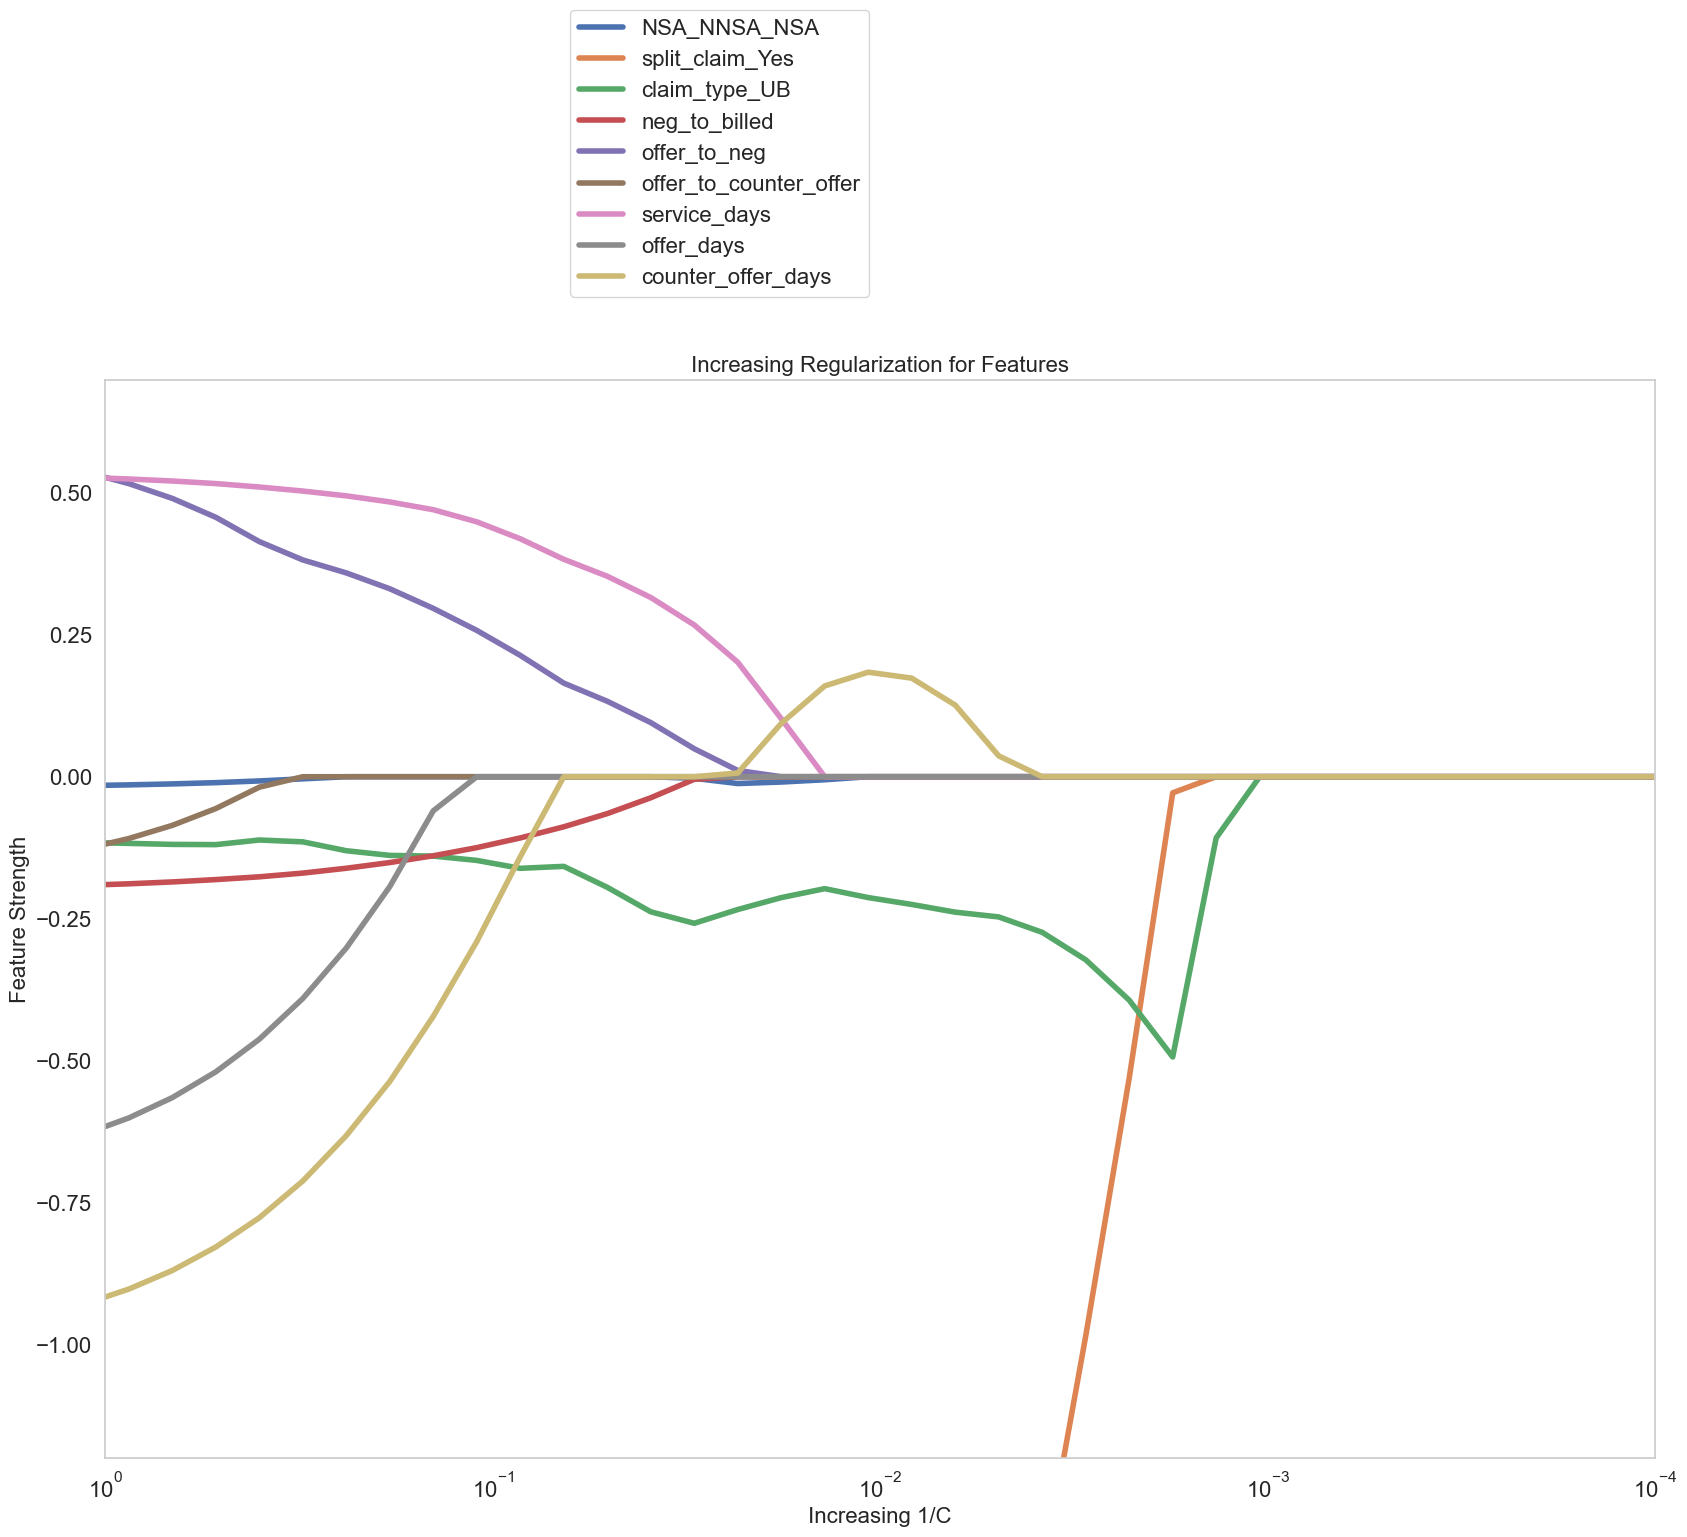

In [388]:
#Visualize feature strength with increasing regularatization
common_fontsize=16
plt.figure(figsize = (20, 14))
plt.semilogx(coef_df, linewidth=4)
plt.gca().invert_xaxis()
plt.grid()
plt.legend(list(coef_df.columns), loc='center right', bbox_to_anchor=(0.5,1.21), fontsize=common_fontsize)
plt.title('Increasing Regularization for Features', fontsize=common_fontsize)
plt.xlabel("Increasing 1/C", fontsize=common_fontsize)
plt.ylabel("Feature Strength", fontsize=common_fontsize)
plt.xticks(fontsize=common_fontsize)
plt.yticks(fontsize=common_fontsize)
plt.xlim(1,0.0001)
plt.ylim(-1.2,0.7)

#### Feature Regularization Observations:
- 1/C tends to stabilize around 1 which means `C` = 1
- offer_to_counter_offer seems like the least important.  However since this information does not corroborate permutation importance and feature selection results we will not act on it.  Instead we will let Feature Selection work for us during Cross-Validation.  

### Summary of Findings
- Dummy Classifier f1 weighted score: 0.588
- We confirmed that it would be helpful to replace the amount fields `billed_amount`, `negotiation_amount`, `offer`, `counter_offer`, with 3 ratio columns as we saw that this reduces multicollinearity and improves the performance across most model types
- Permutation Importance showed that offer_to_neg and offer_to_counter_offer are the most important features across most models
- The `level` feature tends to get excluded in feature selection and tests without it are perhaps slightly better but still mixed.  We will let Feature Selection handle its inclusion/exclusion for us when we do Cross-Validation


- Our Cross-Validation against different values of n features showed that RandomForest and GradientBoosting looked the most promising, especially between n=17 to n=48 features, 
- Regularization stabilizes around 1/C=1 (i.e. C=1)
- Using models with default parameters we see mostly overfit models with test F1 weighted scores reaching up to approximately ~0.93